# Hyperparameter tuning for neural network

> Back Propagation Implementation - December 2024
>
> NEC First Assignment - Universitat Rovira i Virgili
>
> *Andrea Pujals Bocero*

This notebook explores different combinations of hyperparameters to identify the best configuration for a neural network. 
We will evaluate at least 10 combinations of the following hyperparameters:

- **Number of layers**
- **Layer structure**
- **Number of epochs**
- **Learning rate**
- **Momentum**
- **Activation function**

Metrics evaluated:
- **Mean Absolute Percentage Error (MAPE)**
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**

Plots included:
- Scatter plots of predicted vs true values for representative combinations.
- Training and validation loss evolution over epochs.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.NeuralNet import NeuralNet  # Import my neural network implementation
import itertools

In [14]:
#read and parse the .csv features file for A1-synthetic
df = pd.read_csv('A1-synthetic.csv', decimal=".")
df.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,z
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.968392,11.005370,0.511468,2.417192,100.108795,2.726705,78.148504,0.313000,13.868300,6.367773
std,28.418028,0.584090,0.283292,1.147284,4.893623,0.275193,5.016537,0.463946,3.253272,3.841009
min,-49.942910,10.000103,0.000147,1.002395,85.147019,1.974029,62.554174,0.000000,10.100000,-0.791114
25%,-23.938244,10.510135,0.267591,1.258367,96.934414,2.540117,74.814175,0.000000,10.861926,3.124304
50%,2.852507,10.990934,0.515436,3.042135,99.920497,2.710712,78.101481,0.000000,13.089869,5.665139
75%,25.494062,11.517569,0.757415,3.498211,103.482385,2.902578,81.604561,1.000000,16.366096,9.260205
max,49.889593,11.999189,0.999727,3.999776,116.239538,3.600914,94.502170,1.000000,22.033951,16.080230


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,z
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.509967,0.502863,0.511535,0.472011,0.481202,0.462648,0.488116,0.313000,0.315763,0.424322
std,0.284657,0.292178,0.283411,0.382762,0.157389,0.169153,0.157022,0.463946,0.272606,0.227665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.260483,0.255133,0.267556,0.085399,0.379107,0.347958,0.383749,0.000000,0.063845,0.232075
50%,0.528840,0.495642,0.515506,0.680507,0.475146,0.452818,0.486644,0.000000,0.250535,0.382676
75%,0.755635,0.759080,0.757586,0.832666,0.589703,0.570753,0.596294,1.000000,0.525065,0.595763
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
columns = df_scaled.shape[1]

input_columns = df_scaled.columns[0 : 9] # Select the first 9 columns
features = df_scaled[input_columns].values

output_column = df_scaled.columns[9] # Select the 10th column (index 9) as the target
targets = df_scaled[output_column].values

print(features.shape)
print(targets.shape)

(1000, 9)
(1000,)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state= 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 9)
(200, 9)
(800,)
(200,)


In [18]:
def hyperparameter_search(X_train, y_train, X_val, y_val, param_grid):
    """
    Perform hyperparameter search for the given neural network class.
    """
    param_combinations = list(itertools.product(*param_grid.values()))
    results = []

    for params in param_combinations:
        layers, epochs, lr, momentum, activation = params
        
        # Initialize and train the network
        nn = NeuralNet(layers, epochs, lr, momentum, activation, val_split=0.2)
        # Call the fit method
        nn.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = nn.predict(X_val)
        mse = ((y_val - y_pred) ** 2).mean()
        mae = abs(y_val - y_pred).mean()
        epsilon = 1e-7  # A very small value to avoid division by zero
        mape = (abs((y_val - y_pred) / (y_val + epsilon))).mean() * 100


        results.append({
            "Layers": layers,
            "Epochs": epochs,
            "Learning Rate": lr,
            "Momentum": momentum,
            "Activation": activation,
            "MSE": mse,
            "MAE": mae,
            "MAPE": mape
        })

    return pd.DataFrame(results)

In [19]:
# Define hyperparameter grid
param_grid = {
    "layers": [
        [9, 8, 4, 1],  # Simple
        [9, 16, 8, 1]  # Moderate
    ],
    "epochs": [100, 500],
    "learning_rate": [0.01, 0.001],
    "momentum": [0.5, 0.9],
    "activation": ["relu"]  # Activation for hidden layers
}

In [20]:
results = hyperparameter_search(X_train, y_train, X_test, y_test, param_grid)

# Sort and display results
results_sorted = results.sort_values(by="MSE", ascending=True)
print(results_sorted)

Epoch 1/100, Train Loss: 0.22830748157703573, Val Loss: 0.2161498589965763
Epoch 2/100, Train Loss: 0.2283074815770359, Val Loss: 0.2161498589965763
Epoch 3/100, Train Loss: 0.2283074815770358, Val Loss: 0.2161498589965763
Epoch 4/100, Train Loss: 0.2283074815770358, Val Loss: 0.2161498589965763
Epoch 5/100, Train Loss: 0.22830748157703584, Val Loss: 0.2161498589965763
Epoch 6/100, Train Loss: 0.22830748157703584, Val Loss: 0.2161498589965763
Epoch 7/100, Train Loss: 0.22830748157703581, Val Loss: 0.2161498589965763
Epoch 8/100, Train Loss: 0.22830748157703568, Val Loss: 0.2161498589965763
Epoch 9/100, Train Loss: 0.22830748157703581, Val Loss: 0.2161498589965763
Epoch 10/100, Train Loss: 0.22830748157703581, Val Loss: 0.2161498589965763
Epoch 11/100, Train Loss: 0.22830748157703581, Val Loss: 0.2161498589965763
Epoch 12/100, Train Loss: 0.22830748157703584, Val Loss: 0.2161498589965763
Epoch 13/100, Train Loss: 0.22830748157703584, Val Loss: 0.2161498589965763
Epoch 14/100, Train Loss

Best Parameters: Layers           [9, 16, 8, 1]
Epochs                     100
Learning Rate            0.001
Momentum                   0.5
Activation                relu
MSE                   0.055521
MAE                   0.202154
MAPE                 65.108623
Name: 10, dtype: object
Epoch 1/100, Train Loss: 0.06319567235809931, Val Loss: 0.06518310141628327
Epoch 2/100, Train Loss: 0.050539342669628964, Val Loss: 0.05638190785744444
Epoch 3/100, Train Loss: 0.049480802886867126, Val Loss: 0.05639763482080887
Epoch 4/100, Train Loss: 0.049356654729248446, Val Loss: 0.05673072048199478
Epoch 5/100, Train Loss: 0.049355121802413235, Val Loss: 0.05681705834690948
Epoch 6/100, Train Loss: 0.049362429452157686, Val Loss: 0.05667142391723866
Epoch 7/100, Train Loss: 0.04935512601542869, Val Loss: 0.056817244295670116
Epoch 8/100, Train Loss: 0.049355195721635416, Val Loss: 0.0567637291220299
Epoch 9/100, Train Loss: 0.04935542946856852, Val Loss: 0.056828150410226534
Epoch 10/100, Train 

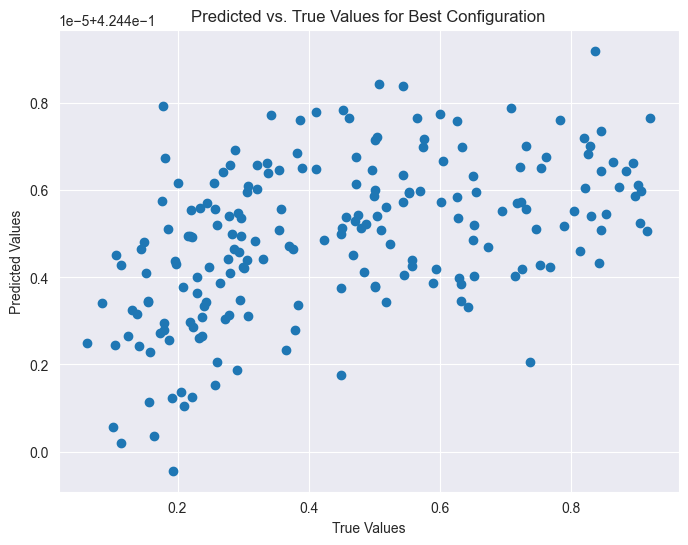

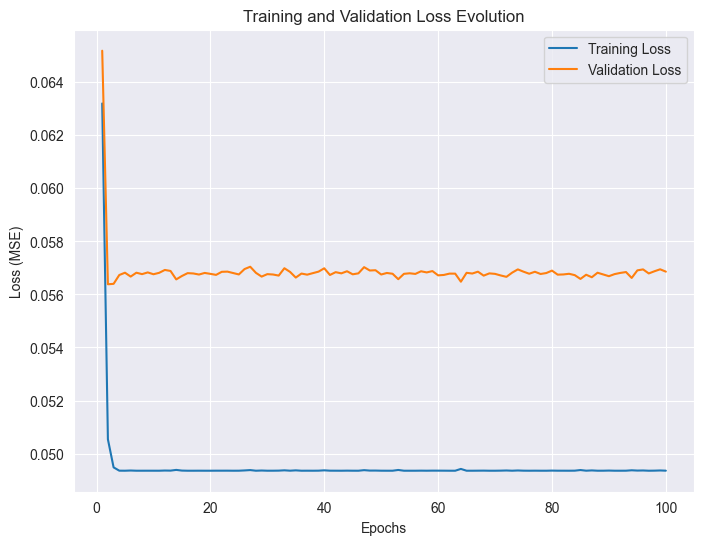

In [21]:
# Best configuration
best_params = results.loc[results["MSE"].idxmin()]
print("Best Parameters:", best_params)

# Scatter plot for best configuration
nn_best = NeuralNet(
    best_params["Layers"],
    best_params["Epochs"],
    best_params["Learning Rate"],
    best_params["Momentum"],
    best_params["Activation"],
    val_split=0.2
)
nn_best.fit(X_train, y_train)
y_best_pred = nn_best.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_best_pred)
plt.title("Predicted vs. True Values for Best Configuration")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Loss plot for best configuration
train_losses, val_losses = nn_best.loss_epochs()
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Evolution")
plt.legend()
plt.show()